In [1]:
from z3 import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
basecond = []

def prove(condition, *precondition):
    # precondition => condition
    # equivalent: not precondition or condition
    # if true not ^ is unsat
    # check precondition and not condition on unsat
    s = Solver()
    s.add(And(*basecond))
    s.add(And(*precondition))
    s.add(Not(condition))
    if s.check() == unsat:
        return "proved"
    else:
        return s.model()

def Prob(name):
    p = Real(name)
    basecond.append(p >= 0)
    basecond.append(p <= 1)
    return p

def ThreePoints(prob, mean, square, t_min, t_max):
    precondition = And(
        0 < prob,
        t_min < mean,
        mean < t_max,
        square - mean**2 >= 0,
        square - mean**2 <= (t_max - mean) * (mean - t_min),
    )
    diff = (square - mean**2) * prob / (t_max - t_min)
    p_min = diff / (mean - t_min)
    p_max = diff / (t_max - mean)
    p_mean = prob - p_min - p_max
    return p_min, p_mean, p_max, precondition

t_min = Real("t_min")
t_max = Real("t_max")
mean = Real("mean")
square = Real("square")
p = Prob("p")

In [3]:
# proof that ThreePoints is correct
p_min, p_mean, p_max, threePointsPrecondition = ThreePoints(p, mean, square, t_min, t_max)
prove(
    And(
        0 <= p_min,
        p_min <= 1,
        0 <= p_mean,
        p_max <= 1,
        0 <= p_max,
        p_max <= 1,
        p == p_min + p_mean + p_max,
        p*mean == p_min * t_min + p_mean * mean + p_max * t_max,
        p*square == p_min * t_min**2 + p_mean * mean**2 + p_max * t_max**2
        
    ),
    threePointsPrecondition
)

'proved'

In [4]:
a = Prob("a")
basecond.append(a > 0)
basecond.append(a < 1)
t = Real("t")
basecond.append(t > t_min)
basecond.append(t < t_max)

Ev = Real("Ev")
Ev0 = Real("Ev_0")
Ev1 = Real("Ev_1")
basecond.append(Ev0 < Ev1)
basecond.append(Ev == a * Ev0 + (1-a) * Ev1)

Sq = Real("Sq")
Sq0 = Real("Sq_0")
Sq1 = Real("Sq_1")
basecond.append(Sq == a * Sq0 + (1-a) * Sq1)
basecond.append(Sq - Ev**2 > 0)
basecond.append(Sq - Ev**2 <= (t_max - Ev)*(Ev - t_min))

d = Sq0 - Ev0**2

p0_min, p0_mean, p0_max, p0cond = ThreePoints(a*p, Ev0, Sq0, t_min, t)
p1_min, p1_mean, p1_max, p1cond = ThreePoints((1-a)*p, Ev1, Sq1, t, t_max)

In [5]:
res = prove(
    And(
        d >= 0,
        d <= (t - Ev0)*(Ev0 - t_min),
        p0_min + p0_mean + p0_max + p1_min + p1_mean + p1_max == p
    ),
    p0cond, p1cond
)
res

'proved'

In [6]:
d1 = Sq1 - Ev1**2
Sq1replace = (Sq - a*Sq0)/(1-a)
Ev1replace = (Ev - a*Ev0)/(1-a)

d1s = substitute(d1, (Sq1, Sq1replace), (Ev1, Ev1replace))
d1f = 1/(1-a)**2 * ((1-a)*(Sq-Ev**2) - a*(1-a)*d - a*(Ev0-Ev)**2)

res = prove(
    And(
        d1 >= 0,
        d1 <= (t_max - Ev1) * (Ev1 - t),
        Ev1 == Ev1replace,
        Sq1 == Sq1replace,
        d1 == d1s,
        d1s == d1f,
        d <= (Sq - Ev**2) / a - (Ev0 - Ev)**2 / (1-a),
        d >= (Sq - Ev**2) / a - (t_max - Ev)*(Ev - t) / a + (t_max - Ev0)*(Ev0 - t)
    ),
    p0cond, p1cond
)
print(res)


d1f

proved


(1/(1 - a)**2)*
((1 - a)*(Sq - Ev**2) -
 a*(1 - a)*(Sq_0 - Ev_0**2) -
 a*(Ev_0 - Ev)**2)

In [7]:
# Auswertung untere und obere Einschränkung von d gegenüberstellen
prove(
    And(
        Ev0 < t, # 1: d0 > und d0 <
        Ev0 > t_min, # 2: d0 > und d0 <
        Ev0 <= Ev/a - (1-a)/a*t, # 3: d1 > und d1 <
        Ev0 >= Ev/a - (1-a)/a*t_max, # 4: d1 > und d1 <
        (Ev0 - Ev)**2 <= (1-a)/a * (Sq - Ev**2), # 5: d0 > und d1 <
        Ev0 <= t - 1/a/(t_max-t_min) * (Sq - Ev**2 - (t_max-Ev)*(Ev-t)), # 6: d0 < und d1 >

        Ev0 < Ev, # (3) mit -t ersetzt durch (1)
    ),
    p0cond, p1cond
)

'proved'

In [8]:
# Auswertung Schranken untere und obere von Ev0 gegenüberstellen
prove(
    And(
        True, # 1 und 2
        a < (t_max - Ev)/(t_max-t), # 1 und 4
        Implies(t < Ev, a <= (Sq - Ev**2)/(Sq - Ev**2 + (Ev-t)**2)), # 1 und 5 >
        a > (t - Ev) / (t - t_min), # 2 und 3
        True, # 2 und 5 <
        # a > (Sq - Ev**2 - (t_max - Ev)*(Ev-t))/(t-t_min)/(t_max-t_min), # 2 und 6
        # 2 und 7 ?
        True, # 3 und 4
        # Implies(t >= Ev, a >= (Ev - t)**2 / ((Ev-t)**2 + Sq - Ev**2)), # 3 und 5 >
        True, # 4 und 5 <
        # a < (t_max - Ev - (Sq - Ev**2 - (t_max -Ev)*(Ev-t))/(t_max-t_min))/(t_max-t)# 4 und 6
        # 5 < und 5 >
        # 5 < und 6 
    ),
    p0cond, p1cond
)

'proved'

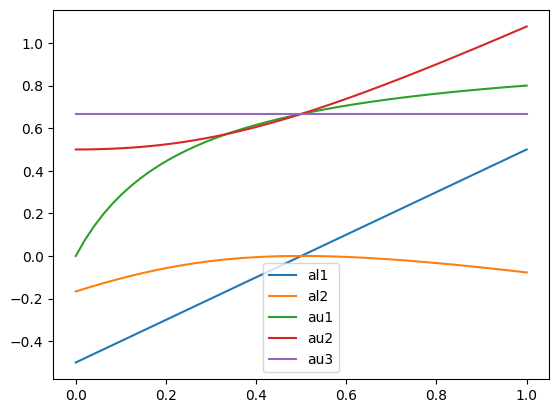

In [9]:
# Bsp für t = -1/2, a in Abhängigkeit von Sq
nSq = np.linspace(0, 1)
al1 = nSq - 1/2
al2 = (2*nSq+1-np.sqrt((4*nSq-1)**2+3))/6
au1= nSq / (1/4 + nSq)
au2 = (2*nSq+1+np.sqrt((4*nSq-1)**2+3))/6
au3 = nSq*0+1/(1+1/2)

fig, ax = plt.subplots()
ax.plot(nSq, al1, label="al1")
ax.plot(nSq, al2, label="al2")
ax.plot(nSq, au1, label="au1")
ax.plot(nSq, au2, label="au2")
ax.plot(nSq, au3, label="au3")
ax.legend()

/tmp/ipykernel_3594558/3039971088.py:7: RuntimeWarning: invalid value encountered in sqrt
  au3 = (4*nt**2+4*nt+4 + np.sqrt((4*nt**2+4*nt+4)**2 - 4*(4*nt**2+4)*(nt**2-2*nt+1/16)))/(8*nt**2+8)


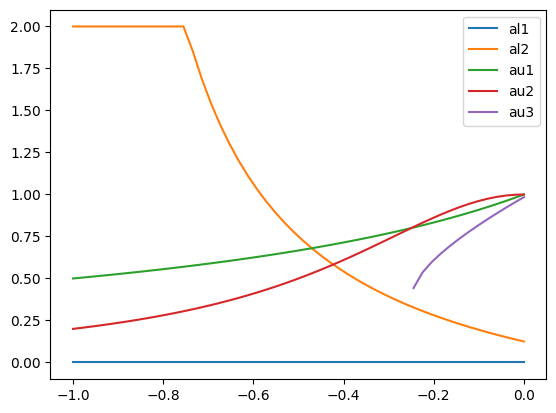

In [10]:
# Bsp für Sq = 1/4, a in Abhängigkeit von t
nt = np.linspace(-0.99999, -0.000001)
al1= 0*nt+0
al2 = np.clip((0.25-nt)/(2*nt+2), -1, 2)
au1 = 1/(1-nt)
au2 = 0.25/(0.25+nt**2)
au3 = (4*nt**2+4*nt+4 + np.sqrt((4*nt**2+4*nt+4)**2 - 4*(4*nt**2+4)*(nt**2-2*nt+1/16)))/(8*nt**2+8)

fig, ax = plt.subplots()
ax.plot(nt, al1, label="al1")
ax.plot(nt, al2, label="al2")
ax.plot(nt, au1, label="au1")
ax.plot(nt, au2, label="au2")
ax.plot(nt, au3, label="au3")
ax.legend()

In [11]:
solve(And(a > 0, 0 >= - 1/Sqrt(a)))

failed to solve
[/0 = [else -> 0]]
